In [1]:
import numpy as np 
import math
import matplotlib.pyplot as plt
import pandas as pd
from random import random
from collections import Counter

In [6]:
import pickle


In [2]:
def make_tree(line) :
    tree = {}
    
    infections = {}
    
    events = line.split(',')
    #print(len(events))
    for column in events :
        if (column != '\n') : 
            info = column.split(':')
            #print("info:",info)
            time= int(info[0]) +0
            parent = int(info[1]) +0
            child =  int(info[2]) +0

            if (parent not in tree.keys()) :
                tree[parent] = {}
                tree[parent]['children'] = [child]
                #print("")
                tree[parent]['parent'] = -1
                tree[parent]['time infected'] = 0

            else : 
                tree[parent]['children'].append(child)

            if (child not in tree.keys()) :
                tree[child] = {}
                tree[child]['parent'] = parent
                tree[child]['children'] = []
                tree[child]['time infected'] = time
            else :
                
                print(tree[child])
                tree[child]['time infected'] = time
                tree[child]['parent'] = parent
#                print("Was here2")
                print(info, "aaaand...")
                print(tree[child])
                print("------")
                
            if (time not in infections.keys()) :
                infections[time] = []
            infections[time].append(child)
                
            tree[parent]['isolated'] = 0
            tree[child]['isolated'] = 0
            
            
    return tree,infections

def get_network(filename) :
    network = {}
    edgelist = pd.read_csv(filename,delimiter = ',')
    print(edgelist.keys())
    
    for edgenum in range (len(edgelist["Node1"])) :
        for node in ["Node1","Node2"]:
            if (int(edgelist[node][edgenum]) not in network) :
                network[int(edgelist[node][edgenum])] = []
                
        network[int(edgelist["Node1"][edgenum])].append(int(edgelist["Node2"][edgenum]))
        network[int(edgelist["Node2"][edgenum])].append(int(edgelist["Node1"][edgenum]))   
        
    return network

In [3]:
# Import network
network = get_network('../inputs/BA_network.csv')

Index(['Node1', 'Node2', 'Brackets'], dtype='object')


In [4]:
found_efficiencies = []

# Import trees...

#file = #open('outputs/EpidemicTrees/EpidemicTrees_NodesDistinguishable1_Dayspresymp3_Daysasymp4_ps0.000_pt0.000_ShapeFlat_Ignoreparents0_Ntrace30_IsolateRightAwayfalse.txt','r')
EpidemicTreePath="../../../../../../../data/jlj/outputs/BackwardTracing/EpidemicTree/"

for ExperimentNumber in range (1,1001):#1001) :#ExperimentNumber=100
    if (ExperimentNumber%10==0): 
        print("Doing ExperimentNumber",ExperimentNumber)
    FileName="Network:BA_Kojaku_InfectiousProfile:Flat_InfectiousWaitExponential:false_AverageR0:1.0_SymptomOnsetTime:immediately_TraceReleaseTime:10000_SeedNumber:250_Ps:0.0_Pt:0.0_ParentFactor:0.5_ChildFactor:0.5_Experiment:%s.txt"%ExperimentNumber
    #"Network:BA_Kojaku_InfectiousProfile:Flat_InfectiousWaitExponential:true_AverageR0:1.0_SymptomOnsetTime:immediately_TraceReleaseTime:10000_SeedNumber:250_Ps:0.0_Pt:0.0_ParentFactor:0.5_ChildFactor:0.5_Experiment:87.txt"
    #"Network:BA_Kojaku_InfectiousProfile:Flat_SymptomOnsetTime:immediately_TraceReleaseTime:10000_SeedNumber:250_Ps:0.0_Pt:0.0_ParentFactor:0.5_ChildFactor:0.5_Experiment:%s.txt"%ExperimentNumber

    file = open(EpidemicTreePath+FileName,'r')

    linenum = -1
    for line in file :
        #print("Doing linenum",linenum, "out of ",100)
        linenum +=1
        #if (linenum==0):
        #    print(line)

        # Make epidemic tree
        for exp in range (10) :
            tree,infections = make_tree(line)
            if (infections!={}) :
                # Count number of seeds visible in tree
                numseeds = 0
                for key in tree :
                    if (tree[key]['parent'] == -1) :
                        numseeds +=1

                seeds_not_visible = 250 - numseeds


                # Now do model
                timemax = max(list(infections.keys()))

                ps = 0.05
                pt = 0.50
                n = 30

                numinfected = 250 # seeds
                numisolated = 0



                for time in range (1,timemax+1) :
                    contactlist = []
                    if (time not in infections.keys()) :
                        infections[time] = []
                    # Go through infections
                    for event in infections[time] :
                        
                        # Check if parent is isolated:
                        parent = tree[event]['parent']+0
                        if (parent != -1 and tree[parent]['isolated'] == 1) :
                            tree[event]['isolated'] = 1
                            # The node did not get infected..
                            
                        else : 

                            # Toss coin to isolate upon infection

                            random_number = random()+0
                            if (random_number < ps) :
                                # Isolate:
                                tree[event]['isolated'] = 1
                                numisolated += 1
                                #print(event)
                                for contact in network[event-1] : #[0-indexing in network, 1-indexing in tree]
                                    # Toss coin to identify contact
                                    random_number = random()
                                    if (random_number < pt) :
                                        contactlist.append(contact+1) #1-indexing in tree.
                            else :
                                numinfected +=1

                    # Now isolate most frequently found contacts
                    if (len(contactlist)!=0) :
                        # find most frequent n traced contacts
                        contactlist = sorted(contactlist, key=Counter(contactlist).get, reverse=True)
                        isolated_contacts = []
                        #for i in range (n) :

                        stop = False
                        listentry = 0
                        while (stop == False) :
                            if (contactlist[listentry] not in isolated_contacts) :
                                isolated_contacts.append(contactlist[listentry])

                            listentry +=1
                            if (len(isolated_contacts) == n or listentry == len(contactlist)) :
                                stop = True

                        # And isolate these n
                        for node in isolated_contacts :
                            # Might try to isolate a node that never got infected...
                            if (node not in tree.keys()) :
                                tree[node] = {'isolated':0}
                            tree[node]['isolated'] = 1
                            numisolated +=1


                Prevented_infections = (len(tree.keys())-numinfected)
                efficiency = Prevented_infections/numisolated                
                found_efficiencies.append(efficiency+0)

Doing ExperimentNumber 10
Doing ExperimentNumber 20
Doing ExperimentNumber 30
Doing ExperimentNumber 40
Doing ExperimentNumber 50
Doing ExperimentNumber 60
Doing ExperimentNumber 70
Doing ExperimentNumber 80
Doing ExperimentNumber 90
Doing ExperimentNumber 100
Doing ExperimentNumber 110
Doing ExperimentNumber 120
Doing ExperimentNumber 130
Doing ExperimentNumber 140
Doing ExperimentNumber 150
Doing ExperimentNumber 160
Doing ExperimentNumber 170
Doing ExperimentNumber 180
Doing ExperimentNumber 190
Doing ExperimentNumber 200
Doing ExperimentNumber 210
Doing ExperimentNumber 220
Doing ExperimentNumber 230
Doing ExperimentNumber 240
Doing ExperimentNumber 250
Doing ExperimentNumber 260
Doing ExperimentNumber 270
Doing ExperimentNumber 280
Doing ExperimentNumber 290
Doing ExperimentNumber 300
Doing ExperimentNumber 310
Doing ExperimentNumber 320
Doing ExperimentNumber 330
Doing ExperimentNumber 340
Doing ExperimentNumber 350
Doing ExperimentNumber 360
Doing ExperimentNumber 370
Doing Expe

In [7]:
PathToOutputs = "outputs/"
with open(PathToOutputs+'KojakuEfficiencyEstimates.pickle', 'wb') as handle:
    pickle.dump(found_efficiencies, handle, protocol=pickle.HIGHEST_PROTOCOL)

(array([  7.,  14.,  34.,  58.,  78., 146., 172., 212., 260., 256., 318.,
        299., 266., 258., 227., 223., 175., 149., 146., 121.,  95.,  89.,
         68.,  66.,  43.,  44.,  36.,  23.,  27.,  19.,  13.,   9.,   8.,
          8.,   6.,   6.,   6.,   6.,   2.,   1.,   0.,   2.,   0.,   0.,
          1.,   0.,   1.,   0.,   0.,   2.]),
 array([11.64337399, 12.5170853 , 13.39079661, 14.26450792, 15.13821923,
        16.01193054, 16.88564185, 17.75935316, 18.63306447, 19.50677578,
        20.38048709, 21.2541984 , 22.12790971, 23.00162102, 23.87533233,
        24.74904364, 25.62275495, 26.49646626, 27.37017757, 28.24388888,
        29.11760019, 29.9913115 , 30.86502281, 31.73873412, 32.61244543,
        33.48615674, 34.35986805, 35.23357936, 36.10729067, 36.98100198,
        37.85471329, 38.7284246 , 39.60213591, 40.47584722, 41.34955853,
        42.22326984, 43.09698115, 43.97069246, 44.84440377, 45.71811508,
        46.59182639, 47.4655377 , 48.33924901, 49.21296032, 50.08667163,
 

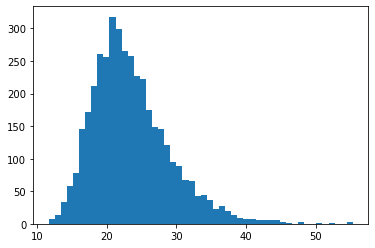

In [8]:
plt.figure()
plt.hist(found_efficiencies,bins=50)

In [11]:
np.mean(found_efficiencies)


23.48070720539853

In [10]:
max(found_efficiencies)

55.32893948472139

In [103]:
min(found_efficiencies)

5.667756169308711

In [104]:
len(tree.keys())

101427

In [106]:
tree[1]

{'parent': 4,
 'children': [48090,
  191684,
  33319,
  129058,
  51052,
  141473,
  50394,
  6023,
  240568,
  33827,
  69741,
  88826,
  15322,
  8152,
  373,
  1992,
  109153,
  237,
  188729,
  40296,
  50135,
  24820,
  1183,
  59037,
  23427,
  68617,
  134305,
  5407,
  44635,
  152178,
  2149,
  2329,
  58264,
  44953,
  74558,
  1492,
  15423,
  35684,
  174004,
  54096,
  112953,
  198211,
  22644,
  126297,
  786,
  24791,
  42060,
  15574,
  169843,
  200604,
  185520,
  96491,
  246665],
 'time infected': 12,
 'isolated': 1}

In [188]:

for ExperimentNumber in range (4,5) :#ExperimentNumber=100
    if (ExperimentNumber%10==0): 
        print("Doing ExperimentNumber",ExperimentNumber)
    #FileName="Network:BA_Kojaku_InfectiousProfile:Flat_InfectiousWaitExponential:true_AverageR0:1.5_SymptomOnsetTime:immediately_TraceReleaseTime:10000_SeedNumber:250_Ps:0.0_Pt:0.0_ParentFactor:0.5_ChildFactor:0.5_Experiment:%s.txt"%ExperimentNumber
    #"Network:BA_Kojaku_InfectiousProfile:Flat_SymptomOnsetTime:immediately_TraceReleaseTime:10000_SeedNumber:250_Ps:0.0_Pt:0.0_ParentFactor:0.5_ChildFactor:0.5_Experiment:%s.txt"%ExperimentNumber
    f=open(EpidemicTreePath+FileName,'r')
    
    for line in f:
        line.strip()
        events = line.split(",")
    
    

In [189]:
len(events
   )

99952

In [190]:
EventsNumber=[]
Number="1"
for event in events :
    info=event.split(":")
    if (Number==info[1] or Number==info[2]) :
        EventsNumber.append(info)

In [191]:
EventsNumber

[['14', '1492', '1'],
 ['15', '1', '56930'],
 ['15', '1', '82'],
 ['15', '1', '18284'],
 ['15', '1', '170119'],
 ['16', '1', '173868'],
 ['16', '1', '171322'],
 ['16', '1', '242278'],
 ['16', '1', '44635'],
 ['16', '1', '224508'],
 ['16', '1', '112953'],
 ['16', '1', '167493'],
 ['17', '1', '1183'],
 ['17', '1', '50917'],
 ['17', '1', '193925'],
 ['17', '1', '7608'],
 ['17', '1', '51864'],
 ['17', '1', '531'],
 ['17', '1', '106362'],
 ['17', '1', '394'],
 ['17', '1', '46899'],
 ['18', '1', '35860'],
 ['19', '1', '52150'],
 ['19', '1', '95499'],
 ['20', '1', '34'],
 ['20', '1', '232152'],
 ['20', '1', '44438'],
 ['20', '1', '19139'],
 ['21', '1', '31553'],
 ['21', '1', '163637'],
 ['21', '1', '83222'],
 ['21', '1', '15322'],
 ['21', '1', '24820'],
 ['22', '1', '152178'],
 ['22', '1', '45356'],
 ['22', '1', '85806'],
 ['22', '1', '50135'],
 ['22', '1', '54096'],
 ['22', '1', '232189'],
 ['23', '1', '72326'],
 ['23', '1', '210957'],
 ['23', '1', '195905'],
 ['23', '1', '204472'],
 ['23', 

In [179]:
numisolated

5434

In [180]:
numinfected

54718

In [181]:
len(tree.keys())

101366

In [182]:
(len(tree.keys())-numinfected)/numisolated

8.584468163415531

In [192]:
seeds

NameError: name 'seeds' is not defined